### Use the influence_data data set or portions of it to create a (multiple) directed network(s) of musical influence, where influencers are connected to followers. Develop parameters that capture ‘music influence’ in this network. Explore a subset of musical influence by creating a subnetwork of your directed influencer network. Describe this subnetwork. What do your ‘music influence’ measures reveal in this subnetwork?

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# load data into DataFrames
artists = pd.read_csv('data_by_artist.csv')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')
full = pd.read_csv('full_music_data.csv')
try:
    tqdm._instances.clear()
except AttributeError:
    pass

In [4]:
def scaleAttr(df, attr):
    """scales the attribute attr of the dataframe df to go from 0 to 1"""
    floor = min(df[attr])
    span = max(df[attr]) - floor
    df[attr] = [(x-floor)/span for x in df[attr]]

In [5]:
songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']        
def artistSimilarity(a1, a2):
    a1Stats = artists[artists['artist_id'] == a1][songStats].to_numpy()
    a2Stats = artists[artists['artist_id'] == a2][songStats].to_numpy()
    if len(a1Stats) == 0 or len(a2Stats) == 0:
        return -1
    return float(cosine_similarity(a1Stats,a2Stats))

In [6]:
# scale tempo columns in each df
scaleAttr(full, 'tempo')
scaleAttr(artists, 'tempo')
scaleAttr(years, 'tempo')

# no dups
artists = artists.drop_duplicates(subset='artist_name', keep='last')

In [7]:
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
allArtists = list(artists['artist_id'])
newdict = {}

#parse id and name columns
full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
scaleAttr(full, 'tempo')

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:].copy()
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)
full


100%|██████████████████████████████████████████████████████████████████████████| 42770/42770 [00:06<00:00, 6332.53it/s]


,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102913,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster,Pop/Rock
102914,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love,Pop/Rock
102915,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese,Pop/Rock
102916,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster,Pop/Rock


In [8]:
# add edges to directed graph
# measure influence 
idDict = {}
for i in tqdm(range(len(artists))):
    try:
        idDict[artists['artist_id'][i]] = artists['artist_name'][i]
    except KeyError:
        pass

influence = pd.read_csv('influence_data.csv')
iGraph = nx.DiGraph()

for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in tqdm(range(len(influence))):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

artIDs = []
artNames = []
followers = []
grandFollowers = []
followerSimilarity = []

for i in tqdm(range(len(iGraph.nodes()))):
    node = list(iGraph.nodes())[i]
    
    children = list(iGraph.successors(node))
    nFollows = len(children)

    grandChildren = []
    similarity = 0
    for child in children:
        sim = artistSimilarity(node,child)
        if sim == -1:
            continue
        for grandChild in iGraph.successors(child):
            grandChildren.append(grandChild)
        similarity += sim
    
    artIDs.append(node)
    try:
        artNames.append(idDict[node])
    except KeyError:
        artNames.append('Unknown')
        
    followers.append(nFollows)
    grandFollowers.append(len(set(grandChildren)))
    try:
        followerSimilarity.append(similarity/nFollows)
    except ZeroDivisionError:
        followerSimilarity.append(0)
    
   
totalInfluence = pd.DataFrame({'artist_name':artNames, 'artist_id':artIDs, 'total_followers':followers,
                               '2nd_degree_followers':grandFollowers, 'follower_similarity':followerSimilarity})
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence = totalInfluence.sort_values(by=['2nd_degree_followers'], ascending = False)
totalInfluence[:10]

100%|██████████████████████████████████████████████████████████████████████████████| 5853/5853 [01:34<00:00, 62.06it/s]


,artist_name,artist_id,total_followers,2nd_degree_followers,follower_similarity
15,The Beatles,754032,615,2690,0.938414
4,Bob Dylan,66915,389,2301,0.933637
5,The Rolling Stones,894465,319,1994,0.949717
128,Chuck Berry,120521,159,1952,0.924118
7,Elvis Presley,180228,166,1950,0.908759
167,Little Richard,824022,88,1858,0.928516
149,James Brown,128099,154,1763,0.944938
138,Jimi Hendrix,354105,201,1679,0.934165
377,Buddy Holly,538677,97,1643,0.944199
446,Bo Diddley,55128,65,1492,0.917627


In [9]:
topInfluencers = totalInfluence.loc[(totalInfluence['2nd_degree_followers']>100)&(totalInfluence['total_followers']>25)&(totalInfluence['artist_name'] != 'Unknown')]
topInfluencers = topInfluencers.reset_index(drop=True)
topInfluencers[:25]

,artist_name,artist_id,total_followers,2nd_degree_followers,follower_similarity
0,The Beatles,754032,615,2690,0.938414
1,Bob Dylan,66915,389,2301,0.933637
2,The Rolling Stones,894465,319,1994,0.949717
3,Chuck Berry,120521,159,1952,0.924118
4,Elvis Presley,180228,166,1950,0.908759
5,Little Richard,824022,88,1858,0.928516
6,James Brown,128099,154,1763,0.944938
7,Jimi Hendrix,354105,201,1679,0.934165
8,Buddy Holly,538677,97,1643,0.944199
9,Bo Diddley,55128,65,1492,0.917627


In [10]:
def getGeneration(row, genDict):
    artist = row['artist_id']
    generation = genDict[artist][0]
    return generation

def rootSimilarity(row, root):
    artist = row['artist_id']
    return artistSimilarity(artist, root)

def getYear(row, full):
    artist = row['artist_id']
    try:
        year = full.loc[artist]['year']
    except KeyError:
        year = 2000
    return year

In [11]:
def subNetwork(root):
    genDict = {}
    lastGen = [root]
    alreadyTracked = []
    
    gen=0
    
    fullList = full.groupby('artists_id').mean()
    
    while True:
        nextGen = []
        for artist in lastGen:
            alreadyTracked.append(artist)
        for artist in lastGen:
            children = list(iGraph.successors(artist))

            genDict[artist] = [gen]
            for child in children:
                if child not in alreadyTracked:
                    nextGen.append(child)

        nextGen = list(set(nextGen))
        if len(nextGen) == 0:
            break

        gen+=1
        lastGen = nextGen
        
    subNetwork = artists[artists['artist_id'].isin(list(genDict.keys()))].copy()

    subNetwork['generation'] = subNetwork.apply(lambda row: getGeneration(row, genDict), axis = 1)
    subNetwork['similarity'] = subNetwork.apply(lambda row: rootSimilarity(row, root), axis = 1)
    subNetwork['year'] = subNetwork.apply(lambda row: getYear(row, fullList), axis = 1)
    
    stats = songStats+['similarity', 'year']
    genSummary = subNetwork.groupby('generation').mean()[stats]
    genSummary['count'] = subNetwork.groupby('generation').count().iloc[:,0]
    
    lastyear = 0
    for i in range(len(genSummary)):
        year = genSummary.iloc[i]['year']
        if year < lastyear:
            break
        lastyear = year
    genSummary = genSummary.iloc[:i].reset_index()
    return genSummary, subNetwork.sort_values('generation').reset_index()

In [12]:
genSum, fullList = subNetwork(754032)#Beatles subnetwork 
genSum

,generation,danceability,energy,valence,tempo,acousticness,instrumentalness,speechiness,similarity,year,count
0,0,0.521975,0.546827,0.619660,0.512870,0.360356,0.051906,0.053395,1.000000,1972.271186,1
1,1,0.511477,0.611554,0.560841,0.527531,0.267512,0.094314,0.050459,0.950782,1984.804907,607
2,2,0.533109,0.658380,0.518283,0.524685,0.227528,0.118893,0.062286,0.921271,1995.880725,2176
3,3,0.567499,0.633423,0.520649,0.507252,0.267354,0.141683,0.077604,0.912522,1996.857913,944


In [13]:
topInfluencers = totalInfluence.loc[(totalInfluence['2nd_degree_followers']>100)&(totalInfluence['total_followers']>25)&(totalInfluence['artist_name'] != 'Unknown')]
topInfluencers[:]

,artist_name,artist_id,total_followers,2nd_degree_followers,follower_similarity
15,The Beatles,754032,615,2690,0.938414
4,Bob Dylan,66915,389,2301,0.933637
5,The Rolling Stones,894465,319,1994,0.949717
128,Chuck Berry,120521,159,1952,0.924118
7,Elvis Presley,180228,166,1950,0.908759
...,...,...,...,...,...
30,Oscar Peterson,489316,26,106,0.902783
82,"Hank Williams, Jr.",117844,28,106,0.974771
742,Max Roach,396372,28,105,0.919808
510,NOFX,317545,29,105,0.981532


In [ ]:
#measure interconnectedness of network as ratio of edges to nodes

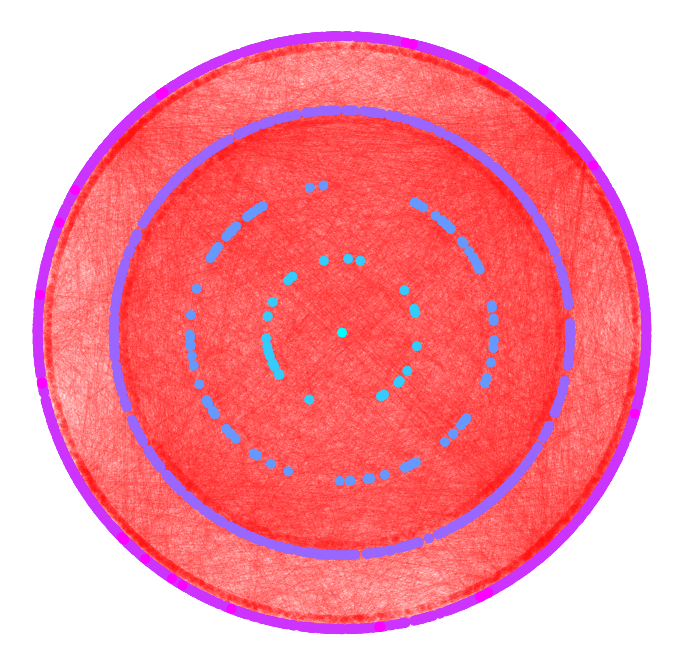

In [38]:
rootNode = 489316 #artist to generate map for
genSum, fullList = subNetwork(rootNode)#coldplay subnetwork 
ourNetwork = fullList[fullList['generation'] < len(genSum)]
artIDs = list(ourNetwork['artist_id'])
H = iGraph.subgraph(artIDs)
def veclength(arr):
    return np.sqrt(arr[0]**2+arr[1]**2)

maxGen = len(genSum)-1

nodepos = {}
for node in H.nodes:
    gen = float(fullList[fullList['artist_id'] == node]['generation'])/2
    a = np.random.random(2) - .5
    dist = veclength(a)
    b = (gen/maxGen)/dist*a + .5
    
    nodepos[node] = list(b)

nodepos[rootNode] = [.5, .5]
G = H
pos = nodepos
ncenter = rootNode

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))
plt.figure(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, alpha=.05, edge_color = 'red')
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(p.keys()),
    node_size=80,
    node_color=list(p.values()),
    cmap=plt.cm.cool   
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()

1369

In [15]:
songStats = ['danceability', 'energy', 'valence', 'tempo', 'mode', 'key', 'liveness', 'acousticness', 'instrumentalness', 'speechiness']        

ful = full[songStats+['genre']].groupby('genre').mean()

def normalize(row, col):
    stat = row[col]
    statMean = table[col]['mean']
    statDev = table[col]['std']
    
    statZ = (stat - statMean)/statDev
    return statZ
    

table = full[songStats].describe()
for col in ful.columns:
    ful[col] = ful.apply(lambda row: normalize(row, col), axis = 1)

xtremes = {}
for i in range(len(ful)):
    row = ful.iloc[i]
    
    extremes = []
    highlows = []
    for j in range(len(row)):
        stat = row.iloc[j]
        abstat = abs(stat)
        if abstat>.5:
            if stat>0:
                highlows.append('High')
            elif stat<0:
                highlows.append('Low')
            extremes.append(row.index[j])
    
    xtremes[row.name] = [extremes, highlows]

traits = pd.DataFrame.from_dict(xtremes, orient = 'index')
traits.columns = ['trait', 'Low/High']
traits

,trait,Low/High
Avant-Garde,"[energy, acousticness]","[Low, High]"
Blues,[acousticness],[High]
Children's,"[danceability, valence, acousticness]","[High, High, High]"
Classical,"[danceability, energy, valence, acousticness, ...","[Low, Low, Low, High, High]"
Comedy/Spoken,"[liveness, acousticness, speechiness]","[High, High, High]"
Country,[],[]
Easy Listening,"[danceability, energy, acousticness, instrumen...","[Low, Low, High, High]"
Electronic,"[acousticness, instrumentalness]","[Low, High]"
Folk,"[energy, acousticness]","[Low, High]"
International,[acousticness],[High]
